<a href="https://colab.research.google.com/github/Minh-A/Pytorch_DeepLearning/blob/main/210121_Time_Series_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전체적인 흐름
## (￣▽￣)ノ

In [ ]:
# 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # GPU, CPU 선택
print('CPU? GPU? : ', device)

CPU? GPU? :  cuda:0


파일 불러오기

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM_pytorch(Dacon)/input/train.csv", encoding = 'euc-kr')
train

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2018-09-09 00:00:00,19,19,8,206
1,2018-09-09 01:00:00,20,19,9,259
2,2018-09-09 02:00:00,12,9,1,48
3,2018-09-09 03:00:00,10,10,2,102
4,2018-09-09 04:00:00,6,5,3,18
...,...,...,...,...,...
19003,2020-11-08 19:00:00,124,123,19,3128
19004,2020-11-08 20:00:00,166,159,29,4864
19005,2020-11-08 21:00:00,184,173,32,3426
19006,2020-11-08 22:00:00,163,155,34,2845


In [ ]:
train['DateTime'] = pd.to_datetime(train.DateTime)  # 데이터 타입을 datetime으로
train['date'] = train.DateTime.dt.date  # 날짜만
train  = train.groupby('date').sum().reset_index()  # 날짜별로 묶음 (합침)
train

,date,사용자,세션,신규방문자,페이지뷰
0,2018-09-09,281,266,73,1826
1,2018-09-10,264,247,51,2092
2,2018-09-11,329,310,58,1998
3,2018-09-12,300,287,45,2595
4,2018-09-13,378,344,50,3845
...,...,...,...,...,...
787,2020-11-04,4516,4472,1196,112683
788,2020-11-05,4155,4037,1044,102901
789,2020-11-06,3663,3576,825,88015
790,2020-11-07,2472,2417,531,57386


전처리

In [ ]:
# 전처리 : 정규화
mini = train.iloc[:,1:].min()  # 날짜를 제외한
size = train.iloc[:,1:].max() - train.iloc[:,1:].min()
train.iloc[:,1:] = (train.iloc[:,1:] -  mini) / size  

input_window = 30       # 모델에 들어가는 날짜
output_window = 5       # 모델을 통해 예측한 날짜

# 행렬을 먼저 만듬
window_x = np.zeros((train.shape[0] - (input_window + output_window), input_window, 4))  # 전체 데이터, 들어갈 데이터, 컬럼수
window_y = np.zeros((train.shape[0] - (input_window + output_window), output_window, 4))


# 슬라이딩 윈도우 생성
for start in range(train.shape[0] - (input_window + output_window)):
    end = start + input_window 

    window_x[start,:, :] = train.iloc[start : end , 1: ].values   # X 데이터셋 만들기
    window_y[start,:, :] = train.iloc[end   : end + output_window, 1: ].values   # 예측할 Y 데이터셋 (훈련시)

In [ ]:
# 슬라이딩 윈도우의 예시
train.iloc[1 : 3, 1:]

,사용자,세션,신규방문자,페이지뷰
1,0.048551,0.045564,0.029586,0.013446
2,0.060550,0.057233,0.033728,0.012842


In [ ]:
# window_x 확인
print(window_x,'\n')
print('모양 확인: ',window_x.shape, '\n')
print('데이터 셋 한개: \n', window_x[0])

tensor([[[0.0517, 0.0491, 0.0426, 0.0117],
         [0.0486, 0.0456, 0.0296, 0.0134],
         [0.0606, 0.0572, 0.0337, 0.0128],
         ...,
         [0.0142, 0.0137, 0.0124, 0.0022],
         [0.0183, 0.0178, 0.0302, 0.0031],
         [0.0126, 0.0124, 0.0136, 0.0016]],

        [[0.0486, 0.0456, 0.0296, 0.0134],
         [0.0606, 0.0572, 0.0337, 0.0128],
         [0.0552, 0.0530, 0.0260, 0.0167],
         ...,
         [0.0183, 0.0178, 0.0302, 0.0031],
         [0.0126, 0.0124, 0.0136, 0.0016],
         [0.0098, 0.0098, 0.0130, 0.0014]],

        [[0.0606, 0.0572, 0.0337, 0.0128],
         [0.0552, 0.0530, 0.0260, 0.0167],
         [0.0696, 0.0635, 0.0290, 0.0247],
         ...,
         [0.0126, 0.0124, 0.0136, 0.0016],
         [0.0098, 0.0098, 0.0130, 0.0014],
         [0.0166, 0.0156, 0.0166, 0.0035]],

        ...,

        [[0.2719, 0.2669, 0.1604, 0.2021],
         [0.2902, 0.2849, 0.1710, 0.2242],
         [0.3109, 0.3047, 0.2118, 0.2249],
         ...,
         [0.7297, 0.7

모델 생성

In [ ]:
# Model 생성

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            batch_first=True)
        self.hidden_lstm = nn.LSTM(input_size = hidden_size,
                                   hidden_size = hidden_size,
                                   batch_first=True)
        self.time_fc = nn.Linear(hidden_size, 4)
    

    def forward(self, x_time):
        out_time, _ = self.lstm(x_time)
        out_time, _ = self.hidden_lstm(out_time)
        out_time, _ = self.hidden_lstm(out_time)
        out_time, _ = self.hidden_lstm(out_time)
        out_time, _ = self.hidden_lstm(out_time)
        out_time = self.time_fc(out_time[:,-5:, :])
        
        return out_time.view(-1,5,4)
  
model = LSTM(input_size = 4, hidden_size = 15).to(device)  # to(device)를 통해 GPU로
model

LSTM(
  (lstm): LSTM(4, 15, batch_first=True)
  (hidden_lstm): LSTM(15, 15, batch_first=True)
  (time_fc): Linear(in_features=15, out_features=4, bias=True)
)

모델 학습

In [ ]:
# 학습 전 데이터 전처리
window_x = torch.tensor(window_x).float().to(device)  # 데이터를 GPU로
window_y = torch.tensor(window_y).float().to(device)

# 훈련
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)  
criterion = nn.MSELoss(size_average = True)
num_epochs  = 500
train_error = []

for t in range(num_epochs):
    train_pred = model(window_x)
    loss = criterion(train_pred, window_y)  
    train_error.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (t +1) % 100 == 0 and t != 1:
        print((t +1), "Epochs train MSE: ", loss.item())

100 Epochs train MSE:  0.010756760835647583
200 Epochs train MSE:  0.008092226460576057
300 Epochs train MSE:  0.007810821756720543
400 Epochs train MSE:  0.0068296222016215324
500 Epochs train MSE:  0.006086647044867277


모델 예측

In [ ]:
last_month = train.iloc[-30:,1:].values[np.newaxis,...]  # 한달 데이터를 불러옴
last_month = torch.tensor(last_month).float().to(device)  # 데이터를 토치화를 하여, GPU로 보냄

for start in range(2):  # 5일씩 2번 예측
    
    next_week = model(last_month)  # 30일 데이터로 5일을 예측
    last_month = torch.cat([last_month[:,5:,:], next_week], axis = 1)  # 훈련데이터에 예측값을 더해 또 예측

    pred_week = next_week.cpu().detach().numpy().reshape(output_window,4)  # 예측한것 CPU

    pred_week = pred_week * size.values + mini.values  # 정규화 해제(정규화를 역을 실행)
    pred_week = pred_week.astype(int)  # 실수 값으로 변환

    print('\n', 5 * (start+1), "일 예측")
    print(pred_week)


 5 일 예측
[[ 2748  2725   626 73579]
 [ 3290  3261   790 89526]
 [ 3430  3348   833 94540]
 [ 3242  3137   770 90030]
 [ 2852  2749   651 79330]]

 10 일 예측
[[ 2406  2259   538 66765]
 [ 2180  2019   474 59563]
 [ 2527  2453   564 68565]
 [ 3050  3066   714 83069]
 [ 3273  3305   779 89827]]


# 온도 데이터를 사용

In [ ]:
# 온도 데이터 불러오기
tem = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/pytorch 책/file/time_series/ta_20210108214059.csv', skiprows=[0,1,2,3,4,5], encoding="cp949")
tem

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,2015-01-01,108,-7.7,-9.8,-4.3
1,2015-01-02,108,-6.0,-9.0,-1.9
2,2015-01-03,108,-2.7,-9.2,3.1
3,2015-01-04,108,2.5,0.2,8.5
4,2015-01-05,108,3.7,-1.1,7.9
...,...,...,...,...,...
2187,2020-12-27,108,5.8,1.4,10.0
2188,2020-12-28,108,6.7,4.2,11.4
2189,2020-12-29,108,0.1,-6.2,4.3
2190,2020-12-30,108,-10.9,-12.9,-6.2


In [ ]:
# 결측치 확인
tem.loc[tem.isna().iloc[:,4] == True,:]

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
1015,2017-10-12,108,11.4,8.8,NaN


In [ ]:
# 앞 뒤의 평균 넣어주기
# 소숫점 둘째 자리에서 반올림
tem.loc[tem.isna().iloc[:,4] == True, '최고기온(℃)'] = round(((tem.iloc[1014,4] + tem.iloc[1016,4]) / 2),2)
tem.loc[1014:1016,:]

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
1014,2017-10-11,108,15.5,12.2,21.7
1015,2017-10-12,108,11.4,8.8,20.3
1016,2017-10-13,108,12.8,6.1,18.9


In [ ]:
# 훈련, 테스트 만들기
train = tem.iloc[:-30,2:]
test = tem.iloc[-30:,2:]

In [ ]:
# 테스트 데이터 예시
tem.iloc[-30:,2:]

,평균기온(℃),최저기온(℃),최고기온(℃)
2162,2.4,0.5,6.1
2163,0.7,-2.3,4.2
2164,-0.6,-4.6,4.4
2165,2.1,-2.2,6.6
2166,4.5,1.2,9.1
2167,3.4,-0.7,6.3
2168,-0.5,-3.5,4.1
2169,1.5,-4.1,6.2
2170,5.8,3.2,9.3
2171,5.3,2.6,9.4


데이터 전처리

In [ ]:
# 전처리
input_window = 90       # 모델에 들어가는 날짜
output_window = 10       # 모델을 통해 예측한 날짜

# 행렬을 먼저 만듬
window_x = np.zeros((train.shape[0] - (input_window + output_window), input_window, 3))  # 전체 데이터, 들어갈 데이터, 컬럼수
window_y = np.zeros((train.shape[0] - (input_window + output_window), output_window, 3))


# 슬라이딩 윈도우 생성
for start in range(train.shape[0] - (input_window + output_window)):
    end = start + input_window 

    window_x[start,:, :] = train.iloc[start : end , : ].values   # X 데이터셋 만들기
    window_y[start,:, :] = train.iloc[end   : end + output_window, : ].values   # 예측할 Y 데이터셋 (훈련시)

LSTM모델

In [ ]:
# Model 생성

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            batch_first=True)
        self.hidden_lstm = nn.LSTM(input_size = hidden_size,
                                   hidden_size = hidden_size,
                                   batch_first=True,
                                   dropout=0.1,
                                   num_layers = 3)
        self.time_fc = nn.Linear(hidden_size, 3)
    

    def forward(self, x_time):
        out_time, _ = self.lstm(x_time)
        out_time, _ = self.hidden_lstm(out_time)

        out_time = self.time_fc(out_time[:,-10:, :])
        
        return out_time.view(-1,10,3)
  
model_lstm = LSTM(input_size = 3, hidden_size = 64).to(device)  # to(device)를 통해 GPU로
model_lstm

LSTM(
  (lstm): LSTM(3, 64, batch_first=True)
  (hidden_lstm): LSTM(64, 64, num_layers=3, batch_first=True, dropout=0.1)
  (time_fc): Linear(in_features=64, out_features=3, bias=True)
)

학습

In [ ]:
# 학습 전 데이터 전처리
window_x = torch.tensor(window_x).float().to(device)  # 데이터를 GPU로
window_y = torch.tensor(window_y).float().to(device)

# 훈련
optimizer = torch.optim.Adam(model_lstm.parameters(), lr = 0.02)  
criterion = nn.MSELoss(size_average = True)
num_epochs  = 1000
train_error = []

for t in range(num_epochs):
    train_pred = model_lstm(window_x)
    loss = criterion(train_pred, window_y)  
    train_error.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (t +1) % 100 == 0 and t != 1:
        print((t +1), "Epochs train MSE: ", loss.item())

100 Epochs train MSE:  12.529302597045898
200 Epochs train MSE:  9.49511432647705
300 Epochs train MSE:  8.180068969726562
400 Epochs train MSE:  5.491964817047119
500 Epochs train MSE:  4.028920650482178
600 Epochs train MSE:  6.7700676918029785
700 Epochs train MSE:  6.921672821044922
800 Epochs train MSE:  4.082592010498047
900 Epochs train MSE:  2.990241527557373
1000 Epochs train MSE:  2.2923355102539062


예측

In [ ]:
last_month = train.values[np.newaxis,...]  # Train 데이터 전체를 넣어서
last_month = torch.tensor(last_month).float().to(device)  # 데이터를 토치화를 하여, GPU로 보냄

lstm_pre = []  # 저장하오

for start in range(3):  # 10일씩 3번 예측
    
    next_week = model_lstm(last_month)  # 30일 데이터로 5일을 예측
    last_month = torch.cat([last_month, next_week], axis = 1)  # 훈련데이터에 예측값을 더해 또 예측

    pred_week = next_week.detach().cpu().numpy().reshape(output_window,3)  # 예측한것 CPU, 넘파이로 (10,4)로 재배열

    lstm_pre.append(pred_week)  # 예측한거 저장하오


# 형식 변환 후, 데이터 프레임으로
lstm_pre = np.array(lstm_pre).reshape(30,3)
lstm_pre = pd.DataFrame(lstm_pre)
lstm_pre = round(lstm_pre,1)

print('30일 예측!! \n')
lstm_pre


30일 예측!! 



,0,1,2
0,2.4,-2.6,7.7
1,3.0,-1.2,7.6
2,2.0,-1.9,6.4
3,3.8,-0.2,8.3
4,2.9,-0.7,6.9
5,2.0,-1.5,6.0
6,1.9,-1.9,6.2
7,2.5,-1.5,7.1
8,4.5,0.4,9.2
9,5.7,2.2,9.8


# 함수당
> 그냥 넘어가슝

In [ ]:
# 함수 뽱뽜라

# 전역변수 처리
window_x = torch.tensor(window_x).float().to(device)
window_y = torch.tensor(window_y).float().to(device)

def predict(model):  # 모델 이름이랑, 저장할 파일명

  global pre_data

  # 훈련
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)  
  criterion = nn.MSELoss(size_average = True)
  num_epochs  = 1000
  train_error = []

  for t in range(num_epochs):
      train_pred = model(window_x)
      loss = criterion(train_pred, window_y)  
      train_error.append(loss)
    
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (t +1) % 100 == 0 and t != 1:
        print((t +1), "Epochs train MSE: ", loss.item())
  
  last_month = train.values[np.newaxis,...]  # Train 데이터 전체를 넣어서
  last_month = torch.tensor(last_month).float().to(device)  # 데이터를 토치화를 하여, GPU로 보냄

  pre_data = []  # 저장하오

  for start in range(3):  # 10일씩 3번 예측
    
    next_week = model(last_month)  # 30일 데이터로 5일을 예측
    last_month = torch.cat([last_month, next_week], axis = 1)  # 훈련데이터에 예측값을 더해 또 예측

    pred_week = next_week.detach().cpu().numpy().reshape(output_window,3)  # 예측한것 CPU, 넘파이로 (10,4)로 재배열

    pre_data.append(pred_week)  # 예측한거 저장하오


  # 형식 변환 후, 데이터 프레임으로
  pre_data = np.array(pre_data).reshape(30,3)
  pre_data = pd.DataFrame(pre_data)
  pre_data = round(pre_data,1)

  print('끝')

GRU 모델

In [ ]:
# Model 생성

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.GRU = nn.GRU(input_size = input_size,
                            hidden_size = hidden_size,
                            batch_first=True)
        self.hidden_GRU = nn.GRU(input_size = hidden_size,
                                   hidden_size = hidden_size,
                                   batch_first=True,
                                   dropout=0.1,
                                   num_layers = 3)
        self.time_fc = nn.Linear(hidden_size, 3)
    

    def forward(self, x_time):
        out_time,_ = self.GRU(x_time)
        out_time,_ = self.hidden_GRU(out_time)

        out_time = self.time_fc(out_time[:,-10:, :])
        
        return out_time.view(-1,10,3)
  
model_GRU = GRU(input_size = 3, hidden_size = 64).to(device)  # to(device)를 통해 GPU로
model_GRU

GRU(
  (GRU): GRU(3, 64, batch_first=True)
  (hidden_GRU): GRU(64, 64, num_layers=3, batch_first=True, dropout=0.1)
  (time_fc): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
predict(model_GRU)
gru_pre = pre_data.copy()

100 Epochs train MSE:  78.47576904296875
200 Epochs train MSE:  26.516347885131836
300 Epochs train MSE:  14.173111915588379
400 Epochs train MSE:  10.316458702087402
500 Epochs train MSE:  8.33225154876709
600 Epochs train MSE:  7.172536373138428
700 Epochs train MSE:  6.148269176483154
800 Epochs train MSE:  5.622565746307373
900 Epochs train MSE:  5.146425247192383
1000 Epochs train MSE:  4.780187129974365
끝


In [ ]:
# Model 생성

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.RNN = nn.RNN(input_size = input_size,
                            hidden_size = hidden_size,
                            batch_first=True)
        self.hidden_RNN = nn.RNN(input_size = hidden_size,
                                   hidden_size = hidden_size,
                                   batch_first=True,
                                   dropout=0.1,
                                   num_layers = 3)
        self.time_fc = nn.Linear(hidden_size, 3)
    

    def forward(self, x_time):
        out_time,_ = self.RNN(x_time)
        out_time,_ = self.hidden_RNN(out_time)

        out_time = self.time_fc(out_time[:,-10:, :])
        
        return out_time.view(-1,10,3)
  
model_RNN = RNN(input_size = 3, hidden_size = 64).to(device)  # to(device)를 통해 GPU로
model_RNN

RNN(
  (RNN): RNN(3, 64, batch_first=True)
  (hidden_RNN): RNN(64, 64, num_layers=3, batch_first=True, dropout=0.1)
  (time_fc): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
predict(model_RNN)
rnn_pre = pre_data.copy()

100 Epochs train MSE:  83.22745513916016
200 Epochs train MSE:  29.254199981689453
300 Epochs train MSE:  15.404851913452148
400 Epochs train MSE:  10.239814758300781
500 Epochs train MSE:  8.999850273132324
600 Epochs train MSE:  6.91591215133667
700 Epochs train MSE:  6.201975345611572
800 Epochs train MSE:  5.577322959899902
900 Epochs train MSE:  5.197918891906738
1000 Epochs train MSE:  5.121532440185547
끝


# 각 모델 결과 비교

In [ ]:
print('\n < LSTM > \n',lstm_pre.head())
print('\n < GRU > \n',gru_pre.head())
print('\n < RNN > \n',rnn_pre.head())
print('\n < REAL > \n',test.head())


 < LSTM > 
      0    1    2
0  2.4 -2.6  7.7
1  3.0 -1.2  7.6
2  2.0 -1.9  6.4
3  3.8 -0.2  8.3
4  2.9 -0.7  6.9

 < GRU > 
      0    1    2
0  2.7 -1.6  7.7
1  2.8 -1.5  7.8
2  3.4 -1.0  8.3
3  3.8 -0.6  8.7
4  4.5 -0.0  9.4

 < RNN > 
      0    1     2
0  0.6 -3.7   5.2
1  1.6 -2.6   6.4
2  3.8 -0.5   8.9
3  5.6  1.2  10.7
4  4.8  0.6  10.0

 < REAL > 
       평균기온(℃)  최저기온(℃)  최고기온(℃)
2162      2.4      0.5      6.1
2163      0.7     -2.3      4.2
2164     -0.6     -4.6      4.4
2165      2.1     -2.2      6.6
2166      4.5      1.2      9.1


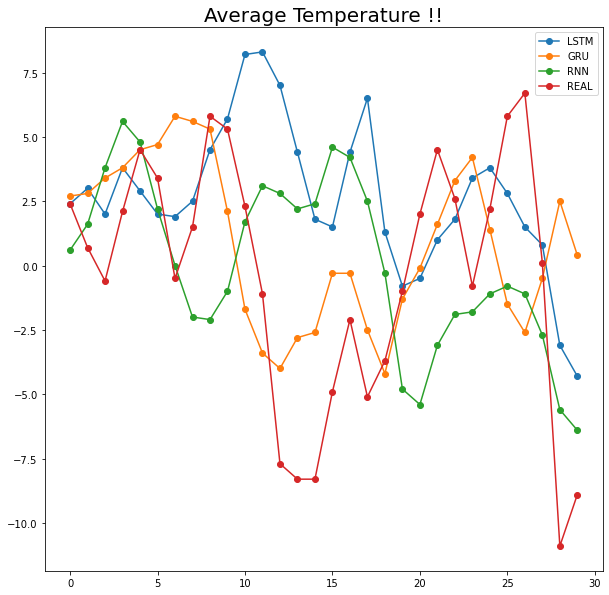

In [ ]:
import matplotlib.pyplot as plt

a = lstm_pre.loc[:,0]
b = gru_pre.loc[:,0]
c = rnn_pre.loc[:,0]
d = test.iloc[:,0].reset_index(drop = True)

fig = plt.figure(figsize=(10,10))  ## 캔버스 생성
fig.set_facecolor('white')       ## 캔버스 색상 설정
ax = fig.add_subplot()           ## 그림 뼈대(프레임) 생성

ax.plot(a, marker='o',label='LSTM')   ## 선그래프 생성
ax.plot(b, marker='o',label='GRU') 
ax.plot(c, marker='o',label='RNN')
ax.plot(d, marker='o',label='REAL') 

ax.legend() ## 범례
 
plt.title('Average Temperature !!',fontsize=20) ## 타이틀 설정
plt.show()

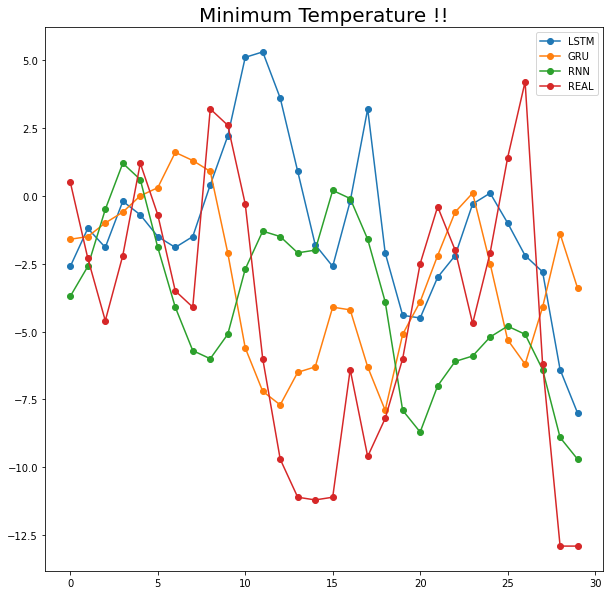

In [ ]:
import matplotlib.pyplot as plt

a = lstm_pre.loc[:,1]
b = gru_pre.loc[:,1]
c = rnn_pre.loc[:,1]
d = test.iloc[:,1].reset_index(drop = True)

fig = plt.figure(figsize=(10,10))  ## 캔버스 생성
fig.set_facecolor('white')       ## 캔버스 색상 설정
ax = fig.add_subplot()           ## 그림 뼈대(프레임) 생성

ax.plot(a, marker='o',label='LSTM')   ## 선그래프 생성
ax.plot(b, marker='o',label='GRU') 
ax.plot(c, marker='o',label='RNN')
ax.plot(d, marker='o',label='REAL') 

ax.legend() ## 범례
 
plt.title('Minimum Temperature !!',fontsize=20) ## 타이틀 설정
plt.show()

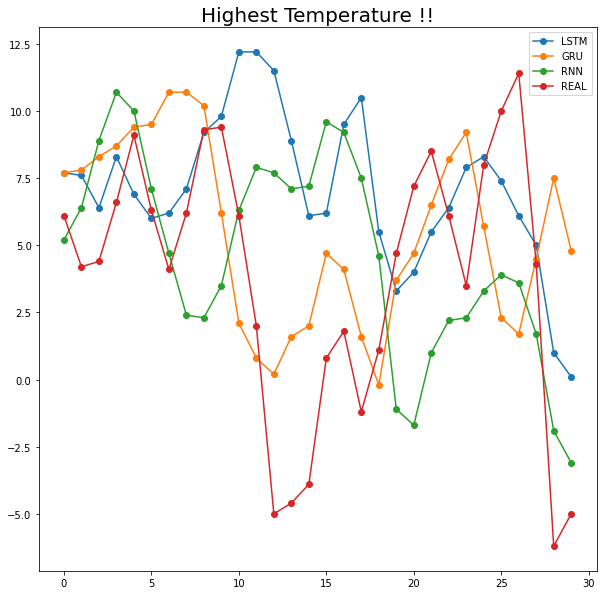

In [ ]:
import matplotlib.pyplot as plt

a = lstm_pre.loc[:,2]
b = gru_pre.loc[:,2]
c = rnn_pre.loc[:,2]
d = test.iloc[:,2].reset_index(drop = True)

fig = plt.figure(figsize=(10,10))  ## 캔버스 생성
fig.set_facecolor('white')       ## 캔버스 색상 설정
ax = fig.add_subplot()           ## 그림 뼈대(프레임) 생성

ax.plot(a, marker='o',label='LSTM')   ## 선그래프 생성
ax.plot(b, marker='o',label='GRU') 
ax.plot(c, marker='o',label='RNN')
ax.plot(d, marker='o',label='REAL') 

ax.legend() ## 범례
 
plt.title('Highest Temperature !!',fontsize=20) ## 타이틀 설정
plt.show()

'͡◕⌒'͡◕? 

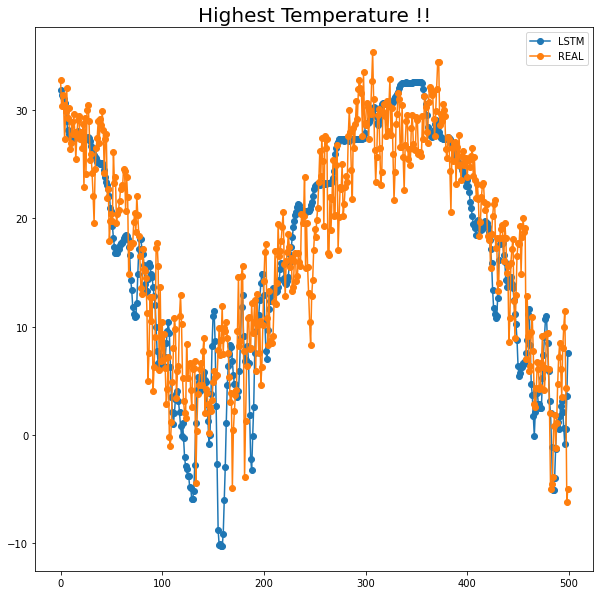

In [ ]:
import matplotlib.pyplot as plt

a = lstm_pre.loc[:,2]

d = test.iloc[:,2].reset_index(drop = True)

fig = plt.figure(figsize=(10,10))  ## 캔버스 생성
fig.set_facecolor('white')       ## 캔버스 색상 설정
ax = fig.add_subplot()           ## 그림 뼈대(프레임) 생성

ax.plot(a, marker='o',label='LSTM')   ## 선그래프 생성

ax.plot(d, marker='o',label='REAL') 

ax.legend() ## 범례
 
plt.title('Highest Temperature !!',fontsize=20) ## 타이틀 설정
plt.show()

> 훈련시 슬라이딩 윈도우를 365일로 10일을 예측



# 고생하셨습니다 !!
## /(^p^)/

# Q&A

저희가 공부한 파이토치 책과의 차이!!
* (LSTM이랑 GRU,RNN의 차이는 무엇일까요?)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            batch_first=True)
        self.hidden_lstm = nn.LSTM(input_size = hidden_size,
                                   hidden_size = hidden_size,
                                   batch_first=True,
                                   dropout=0.1,
                                   num_layers = 3)
        self.time_fc = nn.Linear(hidden_size, 3)
    

    def forward(self, x_time):
        out_time, _ = self.lstm(x_time)
        out_time, _ = self.hidden_lstm(out_time)

        ####################################################################
        #
        # RNN은 out_time, hidden이 들어가고 LSTM은 out_time, (hidden,cell)이 들어가지만
        # out_time,_를 사용하면 모두 사용가능
        #
        ####################################################################

        out_time = self.time_fc(out_time[:,-10:, :])
        
        return out_time.view(-1,10,3)